# RL for RA

In [1]:
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

from gym_reachability import gym_reachability  # Custom Gym env.
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from collections import namedtuple

from KC_DQN.DDQN import DDQN
from KC_DQN.config import dqnConfig

In [2]:
#== CONFIGURATION ==
env_name = "zermelo_kc-v0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CONFIG = dqnConfig(DEVICE=device, ENV_NAME=env_name, 
                   MAX_EPISODES=40000, MAX_EP_STEPS=200,
                   BATCH_SIZE=100, MEMORY_CAPACITY=20000,
                   LR_C=5e-3,
                   GAMMA=.999, GAMMA_PERIOD=2000,
                   EPS_PERIOD=2000, EPS_DECAY=0.6,
                   LR_C_PERIOD=4000, LR_C_DECAY=0.8)
for key, value in CONFIG.__dict__.items():
    if key[:1] != '_': print(key, value)

MAX_EPISODES 40000
MAX_EP_STEPS 200
EPSILON 0.95
EPS_END 0.05
EPS_PERIOD 2000
EPS_DECAY 0.6
LR_C 0.005
LR_C_PERIOD 4000
LR_C_DECAY 0.8
GAMMA 0.999
GAMMA_PERIOD 2000
GAMMA_DECAY 0.5
MEMORY_CAPACITY 20000
BATCH_SIZE 100
TAU 0.01
HARD_UPDATE 1
SOFT_UPDATE True
RENDER False
ENV_NAME zermelo_kc-v0
MAX_MODEL 5
DEVICE cpu
DOUBLE True


[0.999 0.999 0.999 ... 1.    1.    1.   ]


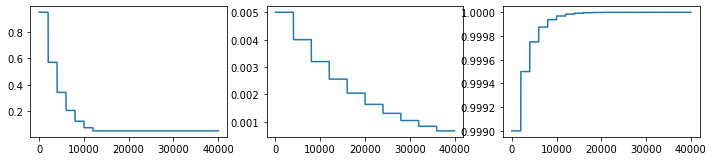

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(12,2.4))

eps = np.zeros(CONFIG.MAX_EPISODES)
lr = np.zeros(CONFIG.MAX_EPISODES)
gamma = np.zeros(CONFIG.MAX_EPISODES)
eps_tmp = CONFIG.EPSILON
lr_tmp = CONFIG.LR_C
gamma_tmp = CONFIG.GAMMA
for i in range(CONFIG.MAX_EPISODES):
    if i != 0 and i % CONFIG.EPS_PERIOD == 0:
        eps_tmp = max(eps_tmp*CONFIG.EPS_DECAY, 0.05)
    if i != 0 and i % CONFIG.LR_C_PERIOD == 0:
        lr_tmp *= CONFIG.LR_C_DECAY
    if i != 0 and i % CONFIG.GAMMA_PERIOD == 0:
        gamma_tmp = min(1-(1-gamma_tmp)*CONFIG.GAMMA_DECAY, 1)
    eps[i] = eps_tmp
    lr[i] = lr_tmp
    gamma[i] = gamma_tmp
ax[0].plot(np.arange(CONFIG.MAX_EPISODES), eps)
ax[1].plot(np.arange(CONFIG.MAX_EPISODES), lr)
ax[2].plot(np.arange(CONFIG.MAX_EPISODES), gamma)
print(gamma)

In [4]:
# == Environment ==
env = gym.make(env_name, device=device, mode='RA')
env.set_costParam(scaling=1.)
print(env.scaling)

# == Discretization ==
grid_cells = (41, 121)
num_states = np.cumprod(grid_cells)[-1]
state_bounds = env.bounds
env.set_discretization(grid_cells, state_bounds)
print(env.spec.id)

s_dim = env.observation_space.shape[0]
action_num = env.action_space.n
print(s_dim, action_num)

action_list = np.arange(action_num)

1.0
zermelo_kc-v0
2 3


/Users/kaichieh/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
s = np.array([-1, 8.5])
env.state = s
print(env.safety_margin(s), env.target_margin(s))
s, c,d,i = env.step(action=2)
print(s, c,d,i)

-0.75 0.25
[-0.95  8.6 ] 0.0 False {'g_x': -0.75, 'l_x': 0.25}


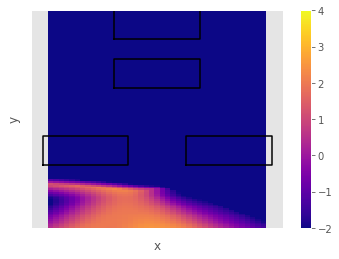

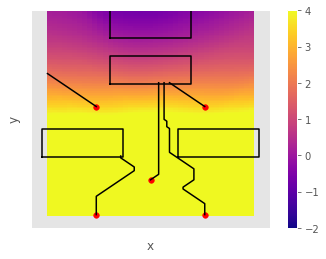

Ep[  0 - (0.95,0.99900,5.0e-03)]: Running/Real cost: 0.10/1.00; success/failure/unfinished rate: 0.000, 1.000, 0.000


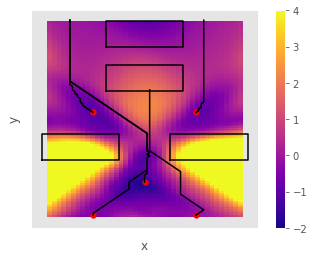

Ep[2000 - (0.57,0.99950,5.0e-03)]: Running/Real cost: 0.99/1.00; success/failure/unfinished rate: 0.000, 1.000, 0.000


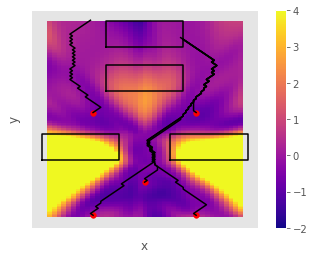

Ep[4000 - (0.34,0.99975,4.0e-03)]: Running/Real cost: 0.94/1.00; success/failure/unfinished rate: 0.800, 0.200, 0.000


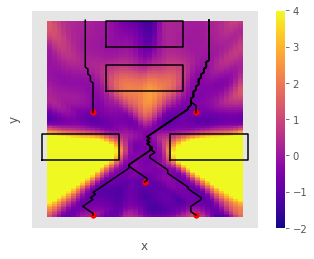

Ep[6000 - (0.21,0.99988,4.0e-03)]: Running/Real cost: 0.81/1.00; success/failure/unfinished rate: 0.000, 1.000, 0.000


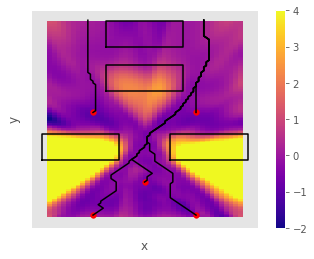

Ep[8000 - (0.12,0.99994,3.2e-03)]: Running/Real cost: 0.38/1.00; success/failure/unfinished rate: 0.000, 1.000, 0.000


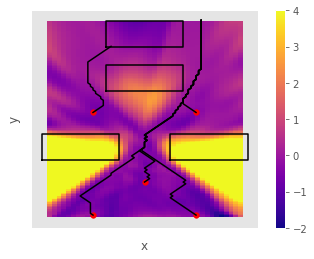

Ep[10000 - (0.07,0.99997,3.2e-03)]: Running/Real cost: 0.36/1.00; success/failure/unfinished rate: 0.200, 0.800, 0.000


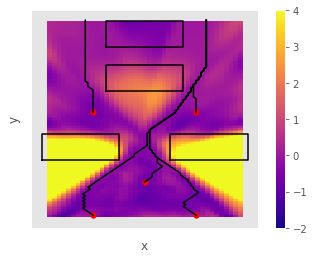

Ep[12000 - (0.05,0.99998,2.6e-03)]: Running/Real cost: 0.24/1.00; success/failure/unfinished rate: 0.000, 1.000, 0.000


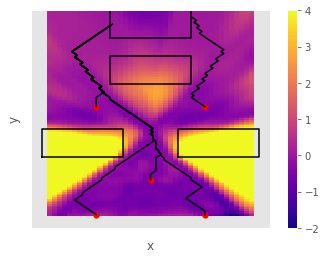

Ep[14000 - (0.05,0.99999,2.6e-03)]: Running/Real cost: 0.50/1.00; success/failure/unfinished rate: 1.000, 0.000, 0.000


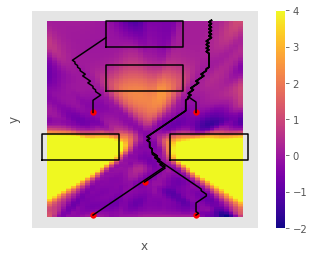

Ep[16000 - (0.05,1.00000,2.0e-03)]: Running/Real cost: 0.75/-1.00; success/failure/unfinished rate: 0.200, 0.800, 0.000


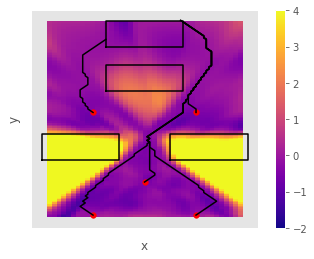

Ep[18000 - (0.05,1.00000,2.0e-03)]: Running/Real cost: -0.03/-1.00; success/failure/unfinished rate: 0.800, 0.200, 0.000


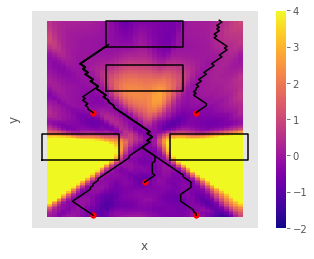

Ep[20000 - (0.05,1.00000,1.6e-03)]: Running/Real cost: -0.04/-1.00; success/failure/unfinished rate: 0.800, 0.200, 0.000


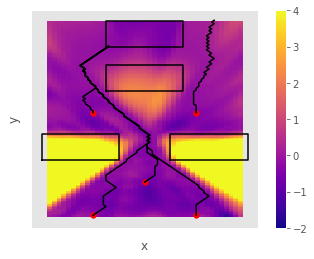

Ep[22000 - (0.05,1.00000,1.6e-03)]: Running/Real cost: -0.04/-1.00; success/failure/unfinished rate: 0.800, 0.200, 0.000


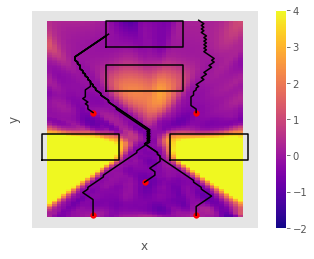

Ep[24000 - (0.05,1.00000,1.3e-03)]: Running/Real cost: -0.13/-1.00; success/failure/unfinished rate: 0.800, 0.200, 0.000


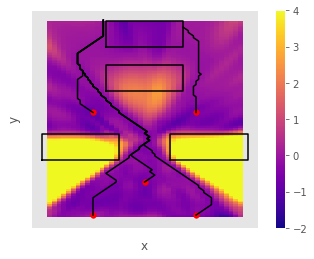

Ep[26000 - (0.05,1.00000,1.3e-03)]: Running/Real cost: -0.02/-1.00; success/failure/unfinished rate: 0.200, 0.800, 0.000


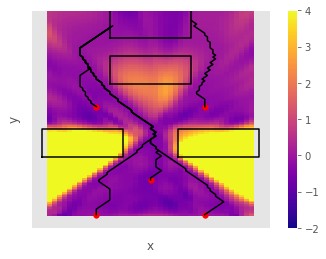

Ep[28000 - (0.05,1.00000,1.0e-03)]: Running/Real cost: 0.48/1.00; success/failure/unfinished rate: 1.000, 0.000, 0.000


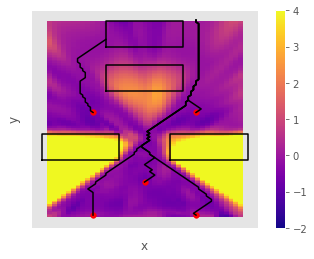

Ep[30000 - (0.05,1.00000,1.0e-03)]: Running/Real cost: 0.09/1.00; success/failure/unfinished rate: 0.200, 0.800, 0.000


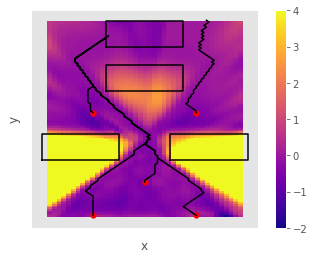

Ep[32000 - (0.05,1.00000,8.4e-04)]: Running/Real cost: -0.02/-1.00; success/failure/unfinished rate: 0.800, 0.200, 0.000


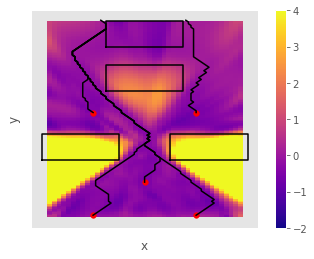

Ep[34000 - (0.05,1.00000,8.4e-04)]: Running/Real cost: 0.43/1.00; success/failure/unfinished rate: 0.600, 0.400, 0.000


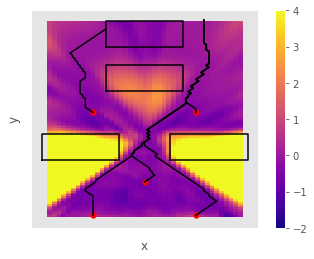

Ep[36000 - (0.05,1.00000,6.7e-04)]: Running/Real cost: 0.27/1.00; success/failure/unfinished rate: 0.200, 0.800, 0.000


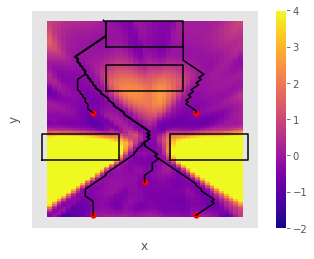

Ep[38000 - (0.05,1.00000,6.7e-04)]: Running/Real cost: -0.32/-1.00; success/failure/unfinished rate: 0.800, 0.200, 0.000


In [6]:
#== AGENT ==
vmin = -2
vmax = 4
agent=DDQN(s_dim, action_num, CONFIG, action_list, mode='RA')
training_records = agent.learn(env, MAX_EPISODES=CONFIG.MAX_EPISODES, MAX_EP_STEPS=CONFIG.MAX_EP_STEPS,
                               running_cost_th=-1, report_period=2000, vmin=vmin, vmax=vmax)

array([ 1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1, -1,  1,  1,
        1, -1,  1,  1, -1,  1,  1,  1, -1,  1, -1,  1, -1,  1,  1,  1, -1,
       -1,  1,  1, -1, -1,  1, -1, -1,  1,  1, -1,  1,  1, -1, -1,  1])

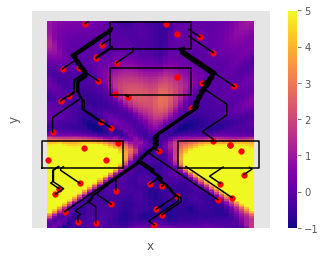

In [10]:
env.visualize_analytic_comparison(agent.Q_network, True, vmin=-1, vmax=5)
#env.plot_trajectories(agent.Q_network, T=60, num_rnd_traj=5, states=env.visual_initial_states)
env.plot_trajectories(agent.Q_network, T=200, num_rnd_traj=50)
#plt.savefig('figure/lagrange_1_1_500.eps')

array([1, 1, 1, 1, 1])

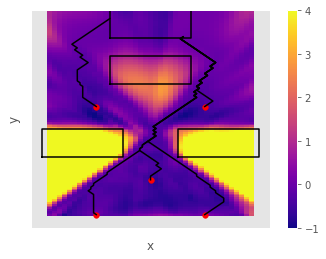

In [9]:
env.visualize_analytic_comparison(agent.Q_network, True, vmin=-1, vmax=4)
env.plot_trajectories(agent.Q_network, T=150, num_rnd_traj=5, states=env.visual_initial_states)